# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [16]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [18]:
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if not test:
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if not test: 
        cv = CountVectorizer(ngram_range=(1, 3), analyzer='char_wb')
        X_cv = cv.fit_transform(movie_data.review)
        fitted_transformations.append(cv)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)

    # Apply HashingVectorizer
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.transform(movie_data.review)
    fitted_transformations.append(hv)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)

    # Combine CountVectorizer and HashingVectorizer results
    X_combined = hstack([X_cv, X_hv])
    
    # Apply TfidfTransformer
    if not test:
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_combined)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_combined)

    # Create additional quantitative features
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    
    # Apply Polynomial Features to quantitative features
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    X_quant_poly = poly.fit_transform(movie_data[["word_count", "punc_count"]])
    print("Look at a few rows of the new quantitative polynomial features: ")
    print(X_quant_poly[:10, :])

    # Combine all quantitative features into a single sparse matrix
    X_quant_poly_csr = csr_matrix(X_quant_poly)
    X_combined = hstack([X_tfidf, X_quant_poly_csr])

    # Feature Scaling for the entire feature set
    if not test:
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_combined)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[3].transform(X_combined)
        print(X.shape)

    # Create Training and Test Sets
    if test:
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return movie_data, X_submission_test
    else:
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return X_train, X_test, y_train, y_test, X_raw_train, X_raw_test


# Create training and test sets from function

In [19]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/mayankmunjal/Downloads/ml-assignment-5/moviereviews_train.tsv', my_random_seed=17)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of CountVectorizer X:
(25000, 38406)
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative polynomial features: 
[[1.000e+00 4.330e+02 2.000e+01 8.660e+03]
 [1.000e+00 1.580e+02 1.600e+01 2.528e+03]
 [1.000e+00 3.78

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [ ]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [31]:
from sklearn import linear_model
from my_measures import BinaryClassificationPerformance

# Set the desired value of C
C = 0.8

# Get the number of samples in the training data
num_samples = X_train.shape[0]

# Initialize SGDClassifier with the specified C value
svm = linear_model.SGDClassifier(alpha=1/(C * num_samples))

# Train the classifier
svm.fit(X_train, y_train)

# Compute performance measures on training data
svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train_C{}'.format(C))
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)


{'Pos': 9989, 'Neg': 10011, 'TP': 9989, 'TN': 10011, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train_C0.8'}


### MODEL: logistic regression

In [ ]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log_loss')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

### MODEL: Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

### MODEL: Perceptron

In [86]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9989, 'Neg': 10011, 'TP': 9989, 'TN': 10011, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [20]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(43990)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9989, 'Neg': 10011, 'TP': 9940, 'TN': 9976, 'FP': 35, 'FN': 49, 'Accuracy': 0.9958, 'Precision': 0.9964912280701754, 'Recall': 0.9950946040644709, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [88]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9989, 'Neg': 10011, 'TP': 7471, 'TN': 7640, 'FP': 2371, 'FN': 2518, 'Accuracy': 0.75555, 'Precision': 0.7590936801463117, 'Recall': 0.7479227149864851, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

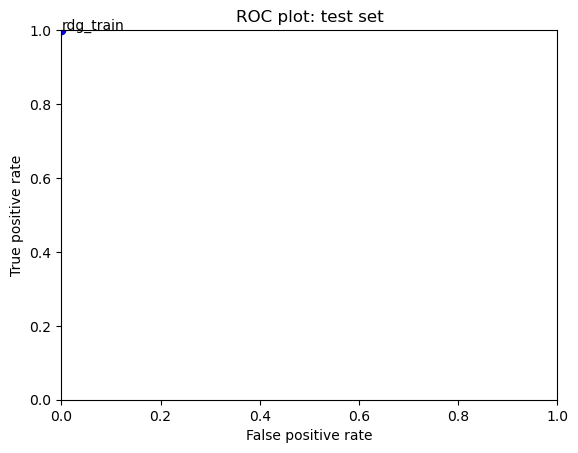

In [7]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [23]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


NameError: name 'ols_predictions' is not defined

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [60]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

NotFittedError: This SGDClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### MODEL: SVM, linear

In [32]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2511, 'Neg': 2489, 'TP': 2087, 'TN': 2088, 'FP': 401, 'FN': 424, 'Accuracy': 0.835, 'Precision': 0.8388263665594855, 'Recall': 0.8311429709279171, 'desc': 'svm_test'}


### MODEL: logistic regression

In [96]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2511, 'Neg': 2489, 'TP': 2125, 'TN': 2104, 'FP': 385, 'FN': 386, 'Accuracy': 0.8458, 'Precision': 0.8466135458167331, 'Recall': 0.8462763839107925, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [91]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2511, 'Neg': 2489, 'TP': 2026, 'TN': 2239, 'FP': 250, 'FN': 485, 'Accuracy': 0.853, 'Precision': 0.8901581722319859, 'Recall': 0.8068498606133014, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [90]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2511, 'Neg': 2489, 'TP': 2127, 'TN': 2136, 'FP': 353, 'FN': 384, 'Accuracy': 0.8526, 'Precision': 0.8576612903225806, 'Recall': 0.8470728793309439, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [9]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2511, 'Neg': 2489, 'TP': 2195, 'TN': 2164, 'FP': 325, 'FN': 316, 'Accuracy': 0.8718, 'Precision': 0.871031746031746, 'Recall': 0.8741537236160892, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [94]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2511, 'Neg': 2489, 'TP': 1772, 'TN': 1853, 'FP': 636, 'FN': 739, 'Accuracy': 0.725, 'Precision': 0.7358803986710963, 'Recall': 0.705694942254082, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

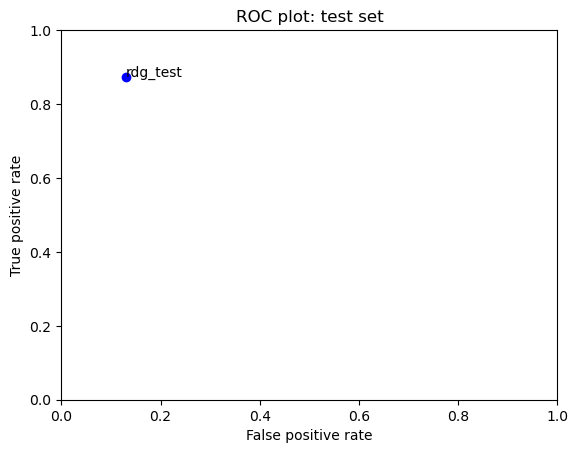

In [10]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [17]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/mayankmunjal/Downloads/ml-assignment-5/moviereviews_test.tsv', my_random_seed=17, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of CountVectorizer X:
(25000, 38406)
Shape of HashingVectorizer X:
(25000, 131072)


AttributeError: 'csr_matrix' object has no attribute 'lower'

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [12]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

NameError: name 'raw_data' is not defined

In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation